# Land Cover Classification

## Description

Having succesfully run the `2_Evaluate_Fit_classifier.ipynb` notebook, we can now use our classification model to predict values on new satellite data. This notebook will guide you through loading satellite data from the ODC, computing the same feature layers as we did in the first notebook when we extracted training data from the ODC, and using our model to classify the satellite data.  We will classify a region of interest, visualize how well our model is performing, and save the results to disk as a Cloud-Optimized GeoTIFF (COG).

The steps are as follows:
1. Import the model we output in the previous notebook, `2_Evaluate_Fit_classifier.ipynb`
2. Redefine the feature layer function that we used to extract training data from the ODC in the first notebook, `0_Extract_Training_Features.ipynb`
3. Loop through a set of locations to extract satellite data from the ODC for a selected region, then compute the feature layers and classify the data using our model.
4. Visualise the classification results
5. Save our results to disk as a COG

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load Packages

In [1]:
%matplotlib inline
import os
import datacube
import warnings
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.algo import xr_geomedian
import xarray as xr
from joblib import load
from deafrica_tools.classification import predict_xr
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import rgb, display_map
from datacube.utils.cog import write_cog
from matplotlib.colors import ListedColormap

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pa

### Set up a dask cluster
This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the dask dashboard, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.

In [2]:
# Set up a dask cluster
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:41709 Dashboard: /user/whusggliuqx@gmail.com/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 12.03 GB


## Analysis parameters

* `rf_model_path`: The path to the location where the model exported from the previous notebook is stored.
* `testing_locations`: A dictionary with values containing latitude and longitude points, and keys representing a unique ID to identify the locations. The `lat` and `lon` points define the center of the satellite images we will load for running small test classifications.
* `buffer`: The size, in decimal degrees, to load around the central latitude and longitude points in `locations`. This number here will depend on the compute/RAM available on the Sandbox instance, and the type and number of feature layers calculated.  
* `dask_chunks`: Dask works by breaking up large datasets into chunks, which can be read individually. This parameter specifies the size of the chunks in numbers of pixels, e.g. `{'x':200,'y':200}`

In [3]:
rf_model_path='Results/Rwanda_RF_model.joblib'
testing_locations = {
    '1': (-1.966, 30.028),
    '2': (-1.520, 29.710),
    '3': (-2.273, 30.489),
}
buffer = 0.01
dask_chunks = {'x':200,'y':200}

## View the selected location
The next cell will display the first location as example on an interactive map. Feel free to zoom in and out to get a better understanding of the area you’ll be predicting. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
# choose the fist testing location
testing_location=testing_locations['1']

# define spatial extent
lon_range=(testing_location[1]-buffer, testing_location[1]+buffer)
lat_range=(testing_location[0]+buffer, testing_location[0]-buffer)

# display basemap
display_map(x=lon_range, y=lat_range)

## Import the model

In [5]:
# load trained classifier
model = load(rf_model_path).set_params(n_jobs=1)
print('loaded random forest model:\n',model)

loaded random forest model:
 RandomForestClassifier(max_features='log2', max_samples=0.5, n_estimators=200,
                       n_jobs=1, random_state=1)


## Making a prediction


### Redefining the feature layer function

Because we elected to use all the features extracted in `0_Extract_Training_Features.ipynb`, we can simply copy-and-paste the `feature_layers` function from the [notebook](0_Extract_Training_Features.ipynb) into the cell below (this has already been done for you). 

If you're using this notebook to run your own classifications (i.e. not running the default example), then you'll need to redefine your feature layer function below, taking care to match the features in the trained model. For example, if you conducted feature selection and removed features from the model, then you'll need to mimic that process here by removing features in the prediction data. In short, the features in the model must precisely match those in the data you're classifying.

In [6]:
# define a function to feature layers
def feature_layers(query): 
    # connect to the datacube so we can access DE Africa data
    dc = datacube.Datacube(app='feature_layers')
    
    # load Sentinel-2 analysis ready data
    ds = load_ard(dc=dc,
                  products=['s2_l2a'],
                  group_by='solar_day',
                  verbose=False,
                  **query)
    
    # calculate NDVI
    ds = calculate_indices(ds,
                           index=['NDVI'],
                           drop=False,
                           satellite_mission='s2')
    
    # interpolate nodata using mean of previous and next observation
#     ds=ds.interpolate_na(dim='time',method='linear',use_coordinate=False,fill_value='extrapolate')

    # calculate bi-monthly geomedian
    ds=ds.resample(time='2MS').map(xr_geomedian)
    
    # stack multi-temporal measurements and rename them
    n_time=ds.dims['time']
    list_measurements=list(ds.keys())
    list_stack_measures=[]
    for j in range(len(list_measurements)):
        for k in range(n_time):
            variable_name=list_measurements[j]+'_'+str(k)
            measure_single=ds[list_measurements[j]].isel(time=k).rename(variable_name)
            list_stack_measures.append(measure_single)
    ds_stacked=xr.merge(list_stack_measures,compat='override')
    return ds_stacked

### Set up datacube query

These query options should match the query params in `0_Extract_Training_Features.ipynb`, unless there are measurements that no longer need to be loaded because they were dropped during a feature selection process (which has not been done in the default example).

In [7]:
time = ('2021')
measurements = ['blue','green','red','red_edge_1','red_edge_2', 'red_edge_3','nir_1','swir_1','swir_2']
resolution = (-10,10)
output_crs='epsg:32735' # WGS84/UTM Zone 35S

### Loop through test locations and predict

For every location we listed in the `test_locations` dictionary, we calculate the feature layers, and then use the DE Africa function [predict_xr](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/83116e80ebb4f8744e3de74e7a713aadd0a7577a/Tools/deafrica_tools/classification.py#L237) to classify the data.

The `predict_xr` function is an xarray wrapper around the sklearn estimator `.predict()` and `.predict_proba()` methods, and relies on [dask-ml](https://ml.dask.org/) [ParallelPostfit](https://ml.dask.org/modules/generated/dask_ml.wrappers.ParallelPostFit.html) to run the predictions with dask. `Predict_xr` can compute predictions, prediction probabilites, and return the input feature layers. Read the [documentation](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/83116e80ebb4f8744e3de74e7a713aadd0a7577a/Tools/deafrica_tools/classification.py#L247) for more insights into this function's capabilities.

As the feature number is large and the geomedians can take some time to calculate, you may expect a few minutes for the prediction to complete in this example.

In [8]:
predictions = []

for key, value in testing_locations.items():
    
    print('working on: ' + key)

     # generate a datacube query object
    query = {
        'x': (value[1]-buffer, value[1]+buffer),
        'y': (value[0]+buffer, value[0]-buffer),
        'time': time,
        'measurements': measurements,
        'resolution': resolution,
        'output_crs': output_crs,
        'dask_chunks' : dask_chunks,
    }

    #calculate features
    data = feature_layers(query)

    #predict using the imported model
    predicted = predict_xr(model,
                           data,
                           proba=False,
                           persist=False,
                           clean=True,
                           return_input=True
                          ).compute()
        
    predictions.append(predicted)

working on: 1
predicting...
   input features...
working on: 2
predicting...
   input features...
working on: 3
predicting...
   input features...


### Plotting results

In the plots below you'll see on the left a true-colour image of the region and on the right the classified image:

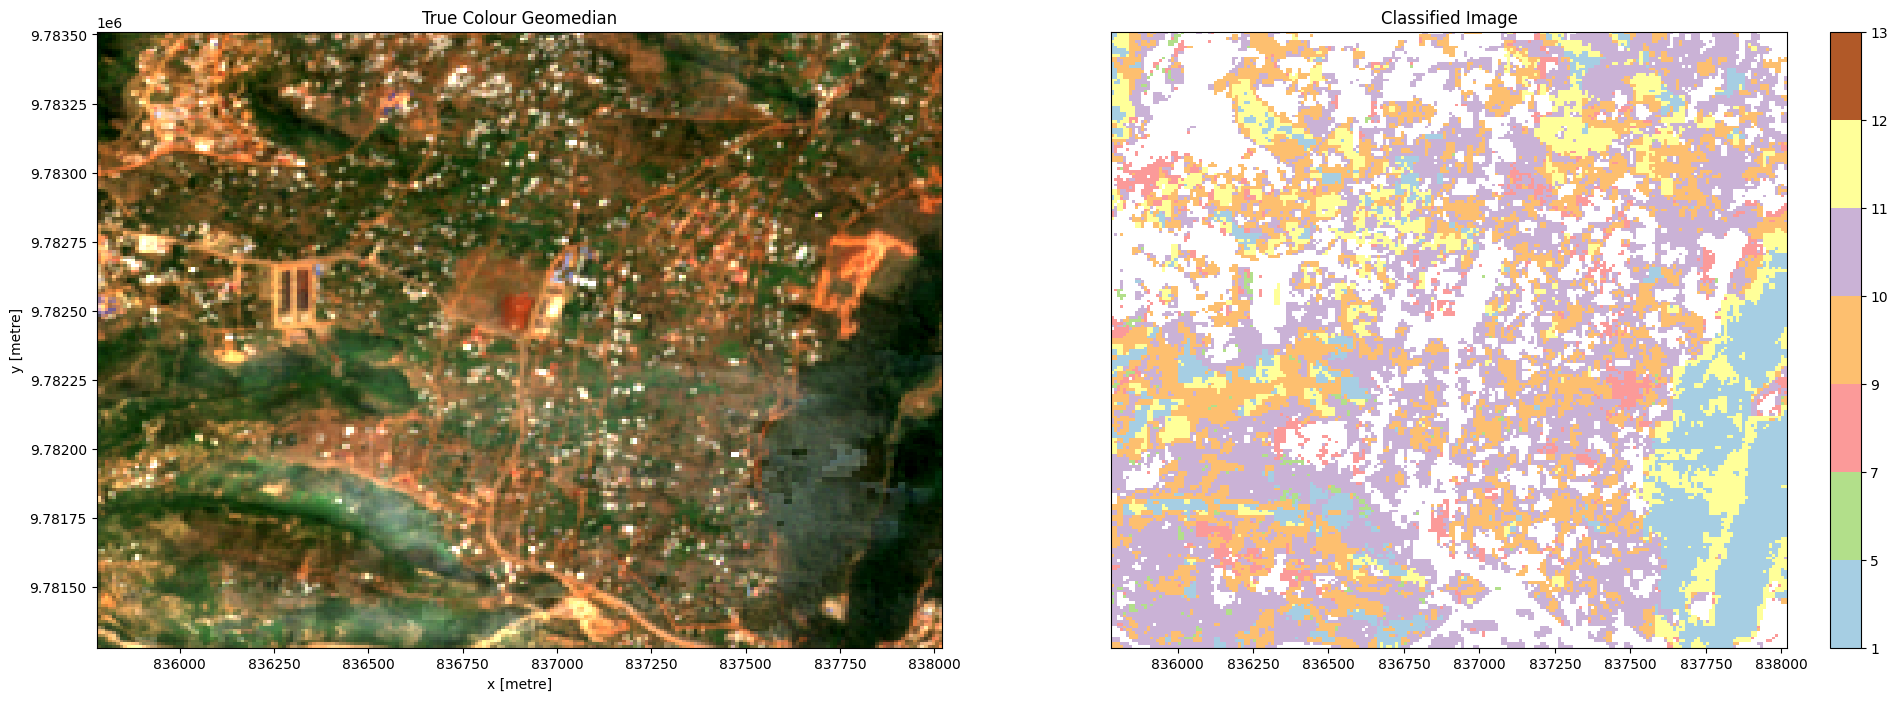

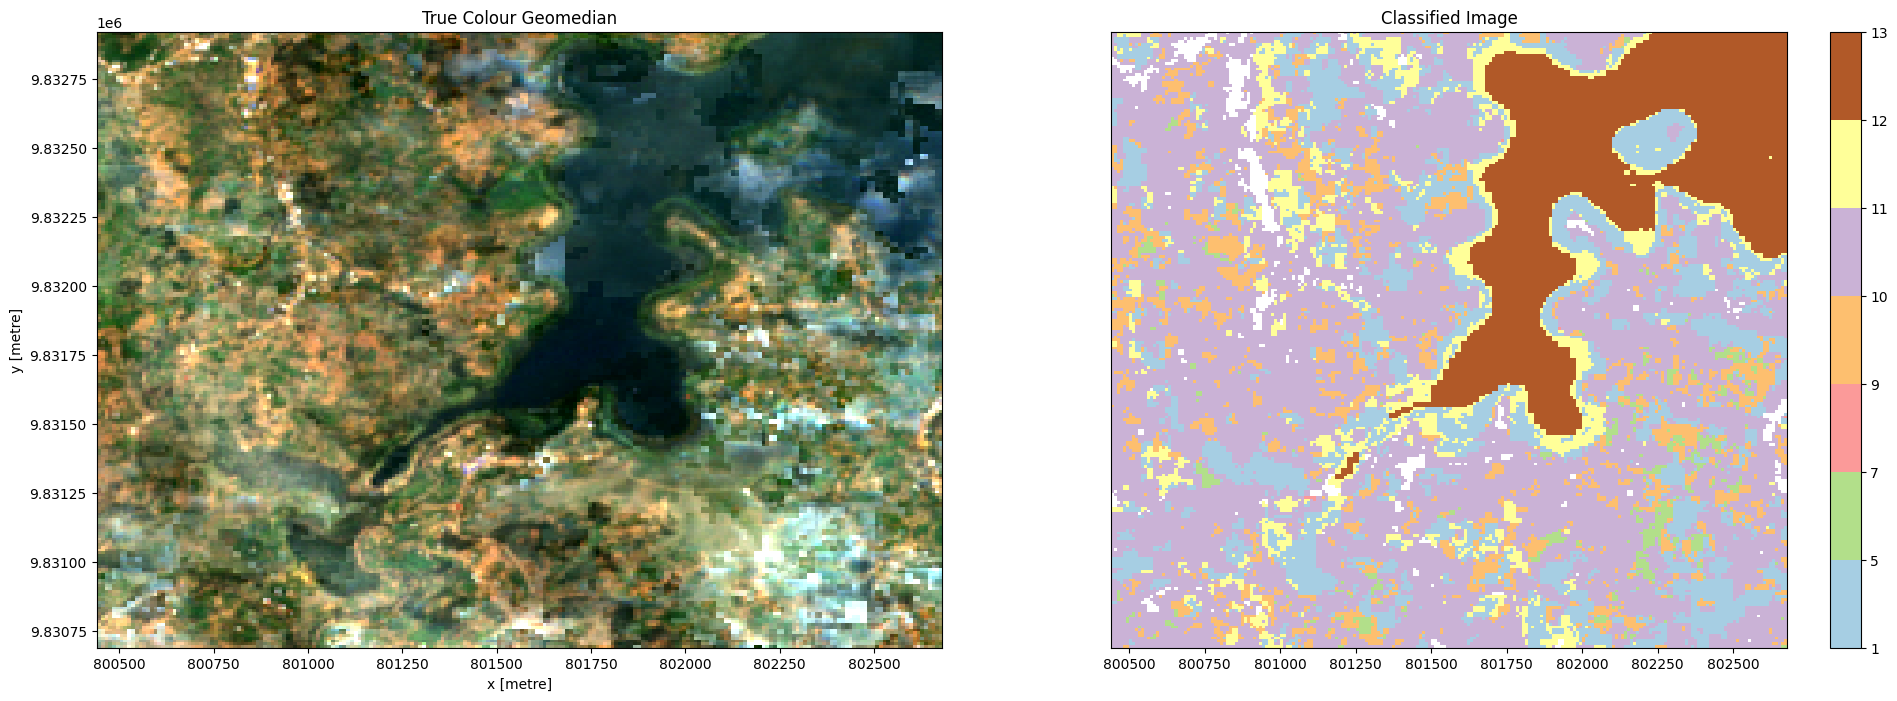

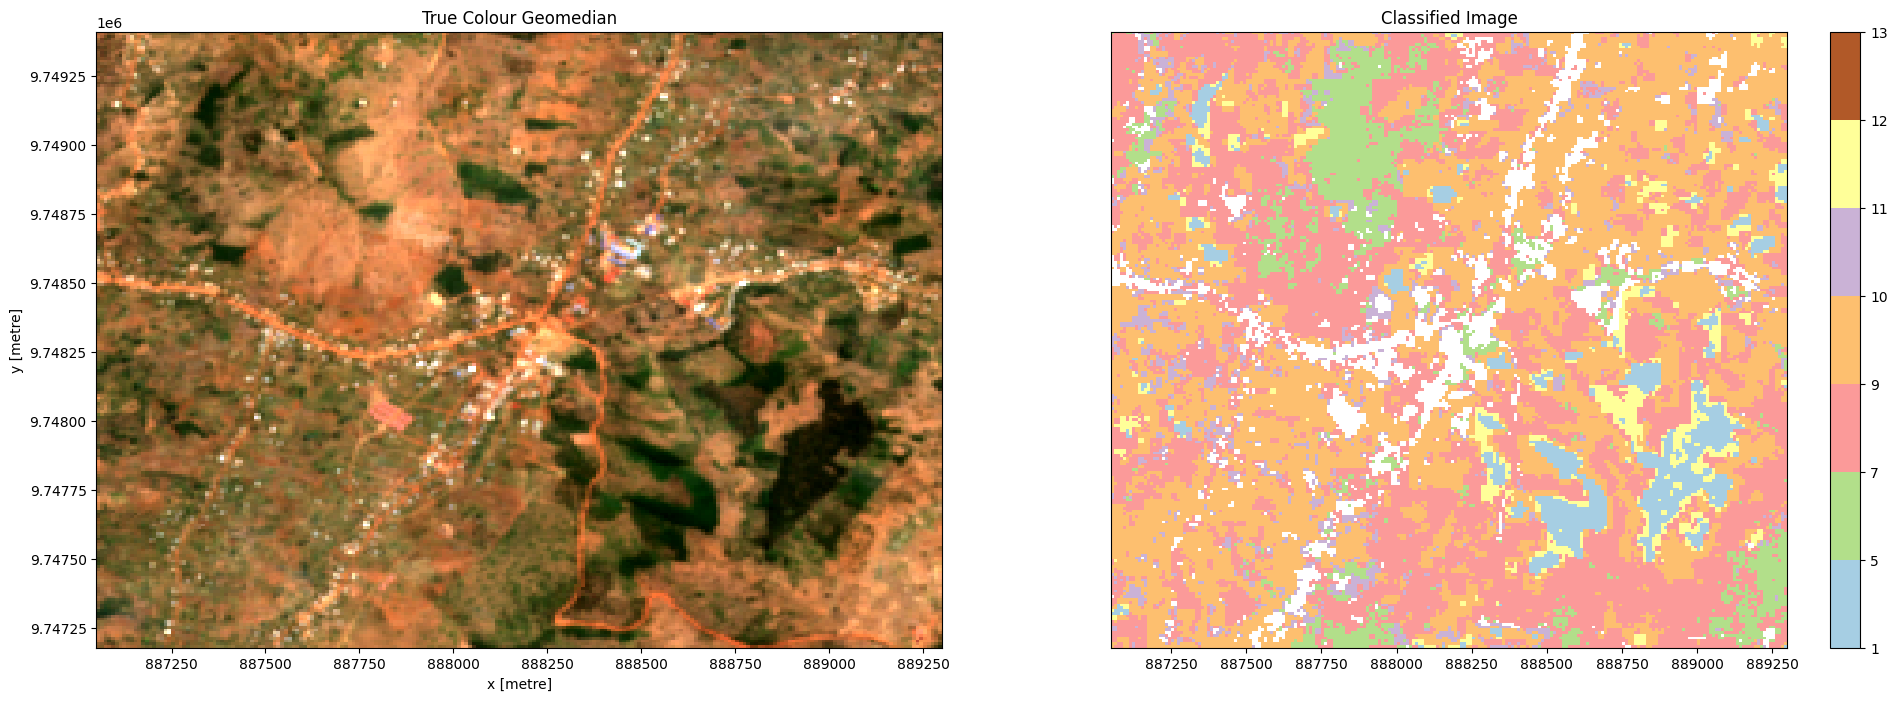

In [27]:
dict_map={1:'Forest',5:'Grassland',7:'Shrubland',9:'Perennial Cropland',10:'Annual Cropland',11:'Wetland',12:'Water Body',13:'Urban Settlement'}
# colours = ['green', 'olive', 'chocolate','magenta','pink','cyan','blue','gray']
for i in range(0, len(predictions)):
    fig, axes = plt.subplots(1, 2, figsize=(24, 8))

    # Plot true colour image
    rgb(predictions[i], bands=['red_3','green_3','blue_3'],
        ax=axes[0], percentile_stretch=(0.01, 0.99))
    
    # todo: show the class names instead of values for better intepretation
    # todo: highest value class not shown?
    # Plot classified image
    predictions[i].Predictions.plot(ax=axes[1],
#                                     cmap=ListedColormap(colours),
                                    cmap='Paired',
                                    add_labels=False, 
#                                     add_colorbar=True,
                                    levels=list(dict_map.keys())
                                    )
    # Remove axis on right plot
    axes[1].get_yaxis().set_visible(False)
    # Add plot titles
    axes[0].set_title('True Colour Geomedian')
    axes[1].set_title('Classified Image')

## Large scale classification

If you're happy with the results of the test locations, then attempt to classify a large region by re-entering a new latitude, longitude and larger buffer size. You may need to adjust the `dask_chunks` size to optimize for the larger region. While you adjust your region size and dask chunk sizes, try to control the size to avoid the computation running out of the RAM limit of your sandbox instance, which will interrupt the calculation.

Nevertheless, in real projects, you may need to produce the land cover map at a national or even global scale. It is suggested that you divide your large study area into smaller tiles so that the computation for a single tile can fit in the RAM limit. Using the spatial extent of each tile, you can adjust the query and loop through all the tiles to produce the classification maps.

## Write the results to GeoTIFFs

We can export our predictions to sandbox disk as Cloud-Optimised GeoTIFFs, which will then be post-processed in our next notebook.

In [30]:
for i in range(0, len(predictions)):
    outname_prediction='Results/Rwanda_land_cover_prediction_2021_location_'+str(i)+'.tif'
    write_cog(predicted.Predictions, outname_prediction, overwrite=True)